<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_sintomas_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Classificação de diagnóstico de COVID-19 a partir de sintomas e fatores de risco

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

## Hiperparâmetros

In [3]:
LOTE_TAMANHO = 2048

CAMADAS = 4

CAMADA_UNIDADES      = 32
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-03-09 19:35:45--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7246 (7.1K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py’

PJI410_funcoes_auxi 100%[===================>]   7.08K  --.-KB/s    in 0s      

2023-03-09 19:35:45 (52.6 MB/s) - ‘PJI410_funcoes_auxiliares.py’ saved [7246/7246]



In [5]:
from PJI410_funcoes_auxiliares import avaliar_previsoes, obter_conjunto, obter_previsoes, set_global_determinism

# Dados

In [6]:
df_sintomas_covid = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas_covid.zip')

In [7]:
df_sintomas_covid['COVID'].value_counts()

1    388617
0    196703
Name: COVID, dtype: int64

## Separação dos dados de treino e teste

In [8]:
X = df_sintomas_covid.drop('COVID', axis=1)
y = df_sintomas_covid['COVID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Datasets

In [9]:
dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Modelos

In [10]:
covid_avaliacoes = [None] * 10

## Modelo 0: SKLearn Decision Tree

In [11]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 4.75 s, sys: 77.1 ms, total: 4.83 s
Wall time: 8.6 s


              precision    recall  f1-score   support

           0       0.52      0.32      0.39     19737
           1       0.71      0.85      0.77     38795

    accuracy                           0.67     58532
   macro avg       0.62      0.58      0.58     58532
weighted avg       0.65      0.67      0.65     58532



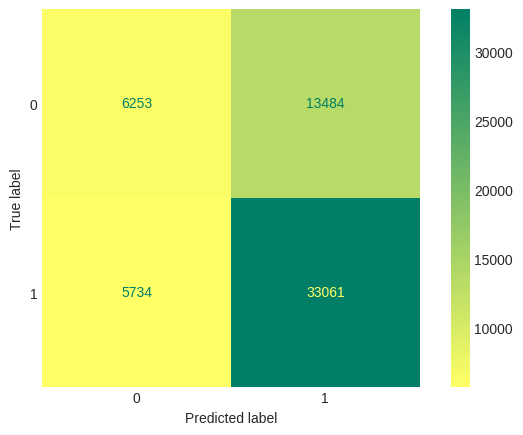

In [12]:
covid_avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

## Modelo 1: SKLearn Random Forest

In [13]:
%%time

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 45.7 s, sys: 753 ms, total: 46.5 s
Wall time: 54.4 s


              precision    recall  f1-score   support

           0       0.55      0.29      0.38     19737
           1       0.71      0.88      0.78     38795

    accuracy                           0.68     58532
   macro avg       0.63      0.58      0.58     58532
weighted avg       0.65      0.68      0.65     58532



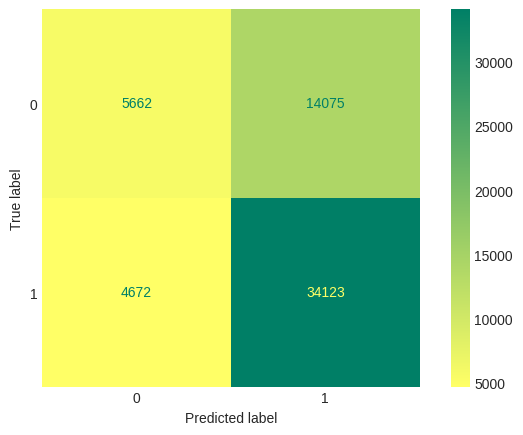

In [14]:
covid_avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

## Modelo 2: SKLearn AdaBoost

In [15]:
%%time

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 19.4 s, sys: 1.08 s, total: 20.5 s
Wall time: 20.6 s


              precision    recall  f1-score   support

           0       0.58      0.23      0.33     19737
           1       0.70      0.92      0.79     38795

    accuracy                           0.68     58532
   macro avg       0.64      0.57      0.56     58532
weighted avg       0.66      0.68      0.64     58532



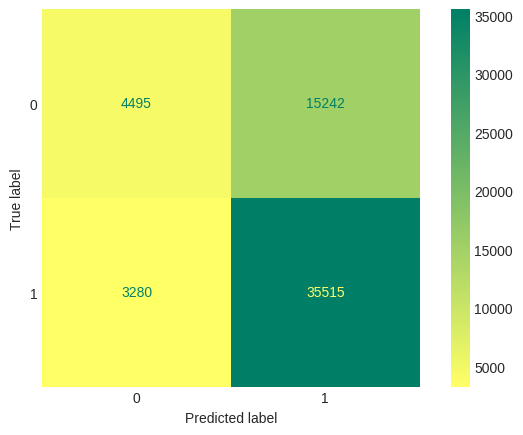

In [16]:
covid_avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

## Modelo 3: SKLearn Gradient Boosting

In [17]:
%%time

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 35.2 s, sys: 70.4 ms, total: 35.2 s
Wall time: 35.3 s


              precision    recall  f1-score   support

           0       0.59      0.26      0.36     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.58      0.58     58532
weighted avg       0.67      0.69      0.65     58532



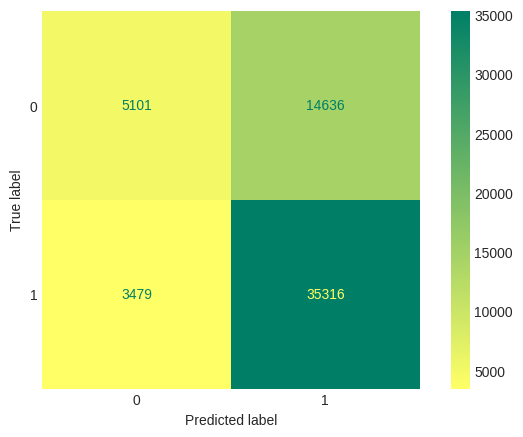

In [18]:
covid_avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

## Modelo 4: XGBoost

In [19]:
%%time

xgb = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 1min 23s, sys: 250 ms, total: 1min 23s
Wall time: 49.8 s


              precision    recall  f1-score   support

           0       0.60      0.27      0.37     19737
           1       0.71      0.91      0.80     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



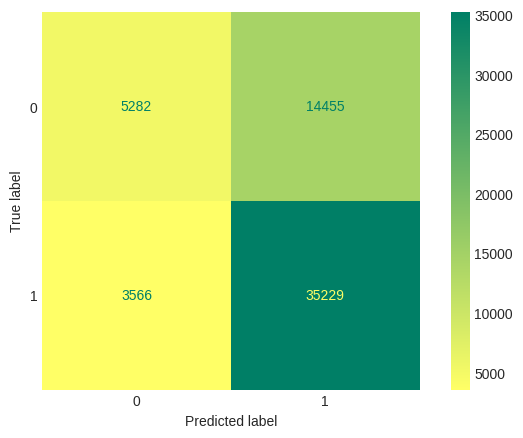

In [20]:
covid_avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

## Modelo 5: TensorFlow Dense

In [21]:
%%time

set_global_determinism(seed=SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 3min 33s, sys: 3.11 s, total: 3min 36s
Wall time: 3min 9s


              precision    recall  f1-score   support

           0       0.58      0.29      0.38     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



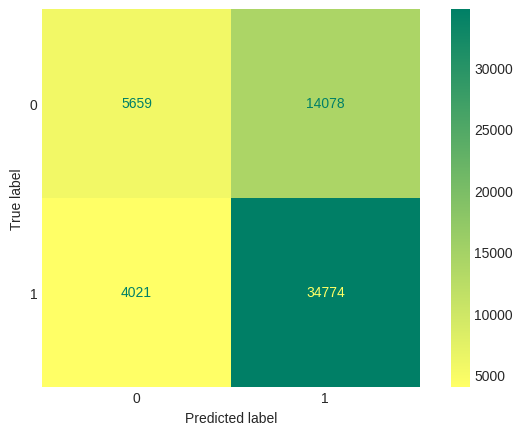

In [22]:
covid_avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

## Modelo 6: TensorFlow Profound

In [23]:
%%time

set_global_determinism(seed=SEMENTE)

tfp = Sequential()

[tfp.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS ** 3)]
tfp.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfp.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfp.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfp.predict(dataset_test, verbose=0))

CPU times: user 14min 44s, sys: 3.33 s, total: 14min 47s
Wall time: 15min 36s


              precision    recall  f1-score   support

           0       0.57      0.30      0.39     19737
           1       0.71      0.88      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.64      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



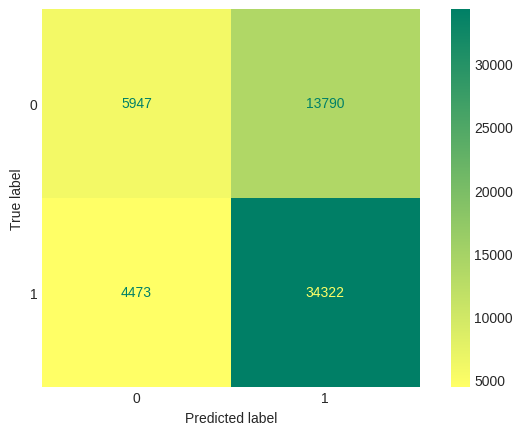

In [24]:
covid_avaliacoes[6] = avaliar_previsoes(y_test, y_pred)

## Modelo 7: TensorFlow Ensemble

In [25]:
%%time

conjunto = obter_conjunto(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5,
                          camadas=CAMADAS, camada_unidades=CAMADA_UNIDADES,
                          camada_inicializador=CAMADA_INICIALIZADOR, camada_ativacao=CAMADA_ATIVACAO,
                          saida_unidades=SAIDA_UNIDADES, saida_ativacao=SAIDA_ATIVACAO,
                          perda=PERDA, otimizador=OTIMIZADOR, aprendizado=APRENDIZADO,
                          metricas=METRICAS, iteracoes=ITERACOES)

Modelo 0 de 5.
Modelo 1 de 5.
Modelo 2 de 5.
Modelo 3 de 5.
Modelo 4 de 5.
CPU times: user 18min 3s, sys: 11.9 s, total: 18min 15s
Wall time: 15min 46s


In [26]:
previsoes = obter_previsoes(conjunto=conjunto, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.59      0.29      0.39     19737
           1       0.71      0.90      0.79     38795

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.59     58532
weighted avg       0.67      0.69      0.66     58532



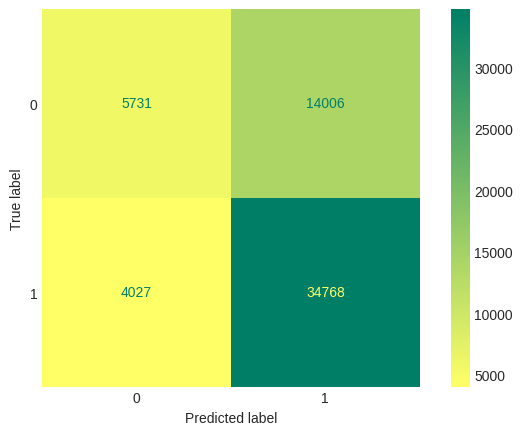

In [27]:
covid_avaliacoes[7] = avaliar_previsoes(y_test, y_pred)

## Comparação de modelos

In [28]:
comparacao = pd.DataFrame([a for a in covid_avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

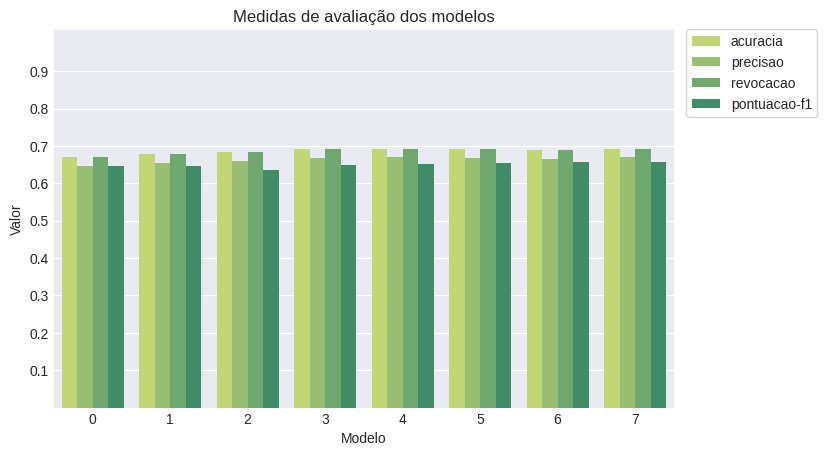

In [29]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.ylim(0.0, 1.01)
plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.legend(loc=(1.02, 0.77), frameon=True, facecolor='white');